In [2]:
#Import PyTorch and matplotlib
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
from pthflops import count_ops

vRead = iio.imread("c_elegans.mp4")
video = np.array(vRead)

#Check PyTorch version
torch.__version__


'1.13.1'

### SET GPU if possible
run in shell: 
CUDA_VISIBLE_DEVICES= {gpu#/#s}

In [3]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled: ", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)

Cuda available:  False
cpu


In [4]:
#Video Metadata
import imageio.v3 as iio
props = iio.improps("c_elegans.mp4")
print("Shape (frames, w, h, RGB): \n" + str(props.shape))
print(props.dtype)

Shape (frames, w, h, RGB): 
(2484, 322, 344, 3)
uint8


### Encoding Image as a Tensor

In [5]:
#Input grid  (width_px, height_ px)
grid = torch.empty(props.shape[1], props.shape[2], 3).to(device)

# Create image tensor
frame = 0
image = torch.tensor(video[frame]).to(device)
image = image.type(torch.int32)

image.shape


torch.Size([322, 344, 3])

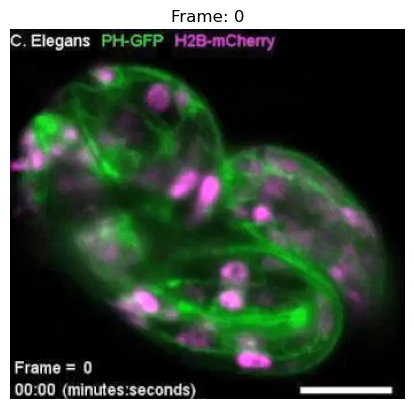

In [6]:
#test original identity output
plt.imshow(image.cpu())
plt.axis(False)
plt.title("Frame: " + str(frame));

### Dataset and DataLoader

In [7]:
import os
from torch.utils.data import DataLoader

class SingleImageDataset(Dataset):
    def __init__(self, image, transform=None, target_transform=None):
        self.image = image.type(torch.int32)
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return int(image.shape[0]) * int(image.shape[1])
    def __getitem__(self, idx):
        row = idx // int(image.shape[1])
        col = idx % int(image.shape[1])
        pixel = torch.tensor(self.image[row][col]).type(torch.int32)
        #label = pixel
        return (row, col), pixel
training_data = SingleImageDataset(image)
#testing_data = None

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
#train_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)


In [8]:
#Test Dataloader
# First index: batch row list and batch col list
testGrid = torch.empty(props.shape[1], props.shape[2], 3).cpu()
testGrid = testGrid.type(torch.int32)


C:\Users\David Martinez\AppData\Local\Temp\ipykernel_8608\3992779240.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel = torch.tensor(self.image[row][col]).type(torch.int32)


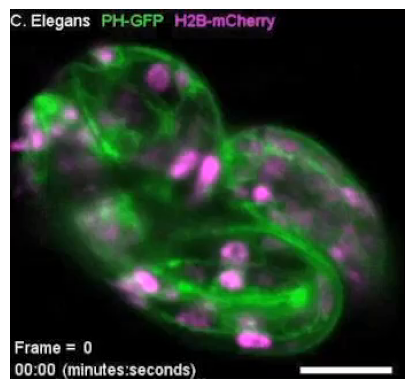

In [9]:
# FOR TESTING PURPOSES ONLY (Verifies sanity of dataset)
for batch in iter(train_dataloader):
    rows = batch[0][0]
    cols = batch[0][1]
    pixels = batch[1]
    for i in range(0, len(rows)):
        row = rows[i]
        col = cols[i]
        pixel = pixels[i]
        testGrid[row][col] = pixel
plt.imshow(testGrid.cpu());
plt.axis(False);

### Main Model

In [28]:
import torch
from torch import nn
#from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

#Use seed for reproducibility
torch.manual_seed(42)
#Multilayer Percepetron Model 
class MLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_shape),
        )
    #forward reconstruction
    def forward(self, X):
        return self.layer_stack(X.to(device))

### Instance of Model (for selected frame/image)

In [29]:
#Create an Instance and set loss function & optimizer
model_0 = MLP(input_shape=2, 
              hidden_units=32, 
              output_shape=3).to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
#list(model_0.parameters())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


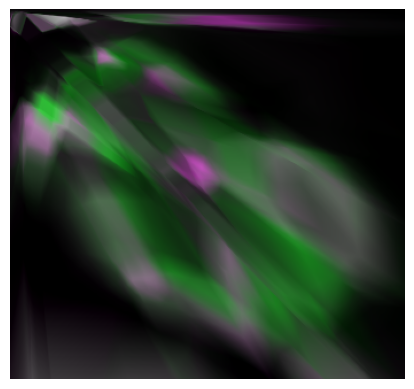

In [27]:
# Tests to reconstruct image for some frame
def test_loop():
    model_0.eval()
    testFrame = torch.zeros(image.shape[0], image.shape[1], 3).type(torch.int32)
    with torch.inference_mode():
        for i in range(0, int(image.shape[0])):
            for j in range(0, int(image.shape[1])):
                testFrame[i][j] = model_0(torch.tensor([1.0 * i, 1.0 * j])).type(torch.float32)
    plt.imshow(testFrame);
    plt.axis(False);
test_loop()

            

### Training Loop

In [32]:
from tqdm import tqdm

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

def trainLoop():
  #Track values
  #Loop through data
  for epoch in tqdm(range(0, 20)):
      ### Training
      model_0.train()
      #Process DataLoader Batch
      for batch in iter(train_dataloader):
        rows = batch[0][0]
        cols = batch[0][1]
        pixels = batch[1]
        #Loop through each pixel in batch
        for i in range(0, len(rows)):
          row = rows[i]
          col = cols[i]
          pixel = pixels[i]
          y_train = torch.tensor([1.0 * pixel[0], 1.0 * pixel[1], 1.0 * pixel[2]]).type(torch.float32)
          
          #1. Forward Pass
          X = torch.tensor([1.0 *row, 1.0 *col]).type(torch.float32)
          y_pred = model_0(X).type(torch.float32)
          #2. Calculate Loss
          loss = loss_fn(y_pred, y_train)
          #3. Optimizer Zero Grad
          optimizer.zero_grad()
          #4. Backpropagation
          loss.backward()
          #5. Step optimizer
          optimizer.step()
        
      if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss}")
        #test_loop()

  print('Training finished')

In [33]:
trainLoop()

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\David Martinez\AppData\Local\Temp\ipykernel_8608\3992779240.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel = torch.tensor(self.image[row][col]).type(torch.int32)


### Reconstruction Visual Tester

### Check Size of Model

In [70]:
# Check model size by summing parameters and state_dict
params_size = 0
for param in model_0.parameters():
    params_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_0.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (params_size + buffer_size) / 1024**2
imageSize = 8 * image.shape[0] * image.shape[1] * image.shape[2]
imageSizeMB = imageSize / (10**6)
perDecrease = (imageSizeMB - size_all_mb) / imageSizeMB
perDecrease *= 100
print('original image size(no compression): {:.3f}MB'.format(imageSizeMB))
print('model size: {:.3f}MB'.format(size_all_mb))
print('Percent decrease in memory size: {:.3f}%'.format(perDecrease))

original image size(no compression): 2.658MB
model size: 0.013MB
Percent decrease in memory size: 99.517%
